# Time of Emergence of the Global Mean

This version differs from the previous version as it is constucted from draft_03_v2 which uses version that have been shifted to functions and standardised.

In [10]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from itertools import groupby

# Third-Party Library Imports
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotllib.gridspec as GridSpec

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import climate_utils
import plotting_utils
import stats
import time_of_emergence_plots
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
import time_of_emrgence_calc as toe

In [4]:
# from dask.distributed import Client
# client = Client()
# client

In [5]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=False)

# Opening Best

In [29]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'

os.listdir(os.path.join(ROOT_DIR, 'best'))

['Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [49]:
best_ds = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)['temperature']

best_ds['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds.time.values))
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

In [50]:
best_ds_smean = climate_utils.weighted_lat_lon_mean(best_ds)

In [51]:
# Only 43MB - load into memory
best_ds_smean = best_ds_smean.compute()

In [52]:
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... 1.025 0.8704 0.9127 1.204 1.273
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [53]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds_smean.where(best_ds_smean.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50)>
-0.3587 -0.2924 -0.2442 -0.26 -0.2722 ... -0.2842 -0.193 -0.1842 -0.3879 -0.2289
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [54]:
base_period_ds_average = base_period_ds.mean(dim='time')
base_period_ds_average

<xarray.DataArray 'temperature' ()>
-0.2854

In [55]:
# Resetting the anomlies to 1850
best_ds_smean = best_ds_smean - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

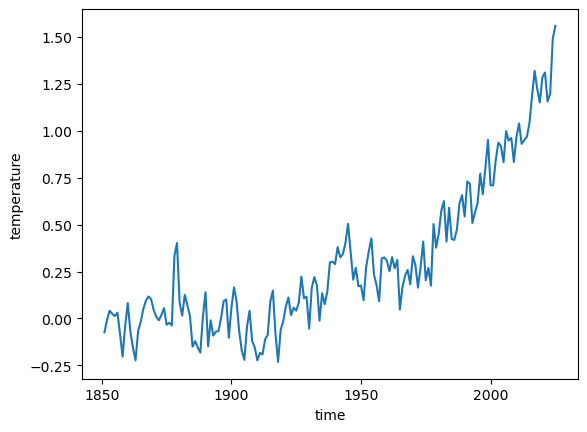

In [56]:
best_ds_smean.plot()

# Calculations

In [57]:
window = 20

## Signal-to-Noise

In [58]:
# As these are anomalies, the signal is just going to be the
ds_best_smooth = stats.trend_fit(best_ds_smean, 'LOWESS', lowess_window=40)#method='POLYNOMIAL', order=4)#

In [59]:
noise_ds = base_period_ds.std(dim='time').to_numpy()
noise_ds

array(0.11661159)

In [60]:
# I know that the temperature is already an anomly, but it cleary wasn't in 
# reference to my base period. This should just translate the data updwardss,
# increasing the signal, so that the baser period is now centered on zero.

ds_best_smooth_signal = ds_best_smooth#- base_period_ds_average

In [61]:
ds_best_sn = ds_best_smooth_signal/noise_ds
ds_best_sn

<xarray.DataArray 'temperature' (time: 175)>
-0.3279 -0.3072 -0.2862 -0.2647 -0.2428 ... 10.81 11.02 11.23 11.43 11.64
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [62]:
ds_best_sn.attrs = {'longname': 'Signal-to-Noise Ratio'}

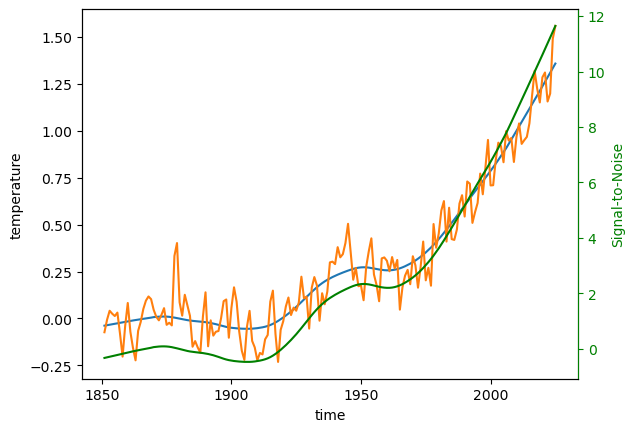

In [63]:
fig, ax = plt.subplots()
ax_twinx = ax.twinx()
ds_best_smooth.plot(ax=ax)
best_ds_smean.plot(ax=ax)
ds_best_sn.plot(ax=ax_twinx, color='green')

ax_twinx.set_ylabel('Signal-to-Noise', color='green')
ax_twinx.tick_params(axis='y', color='green', labelcolor='green')
ax_twinx.spines['right'].set_color('green')

## p-value tests

In [108]:
reload(toe)

<module 'time_of_emrgence_calc' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py'>

In [109]:
# This version is better
ks_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ks_pvalue)
ttest_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_ttest_pvalue)
anderson_ds = toe.stats_test_1d_xr(best_ds_smean, window=window, stats_func=toe.return_anderson_pvalue)

In [110]:
ks_ds

<xarray.DataArray 'temperature' (time: 155)>
0.9999 0.9999 0.9999 0.9999 0.9999 ... 1.235e-17 1.235e-17 1.235e-17 1.235e-17
Coordinates:
  * time     (time) object 1860-12-31 00:00:00 ... 2014-12-31 00:00:00

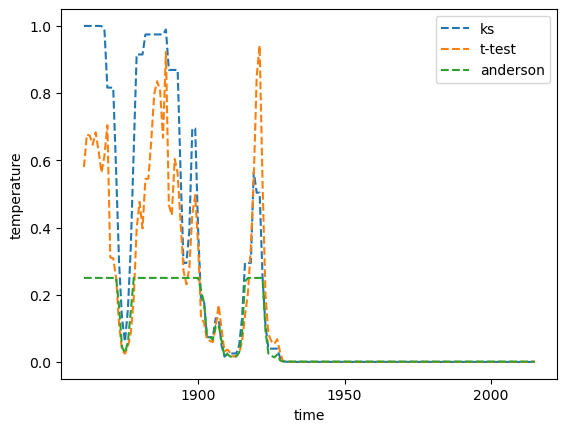

In [111]:
ks_ds.plot(label='ks', linestyle='--')
ttest_ds.plot(label='t-test', linestyle='--')
anderson_ds.plot(label='anderson', linestyle='--')

plt.legend()

# Getting ToE

In [127]:
PVALUE_THESHOLD1 = 0.01

In [121]:
ds_best_sn.name = 'signal_to_noise'
ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
anderson_ds.name = 'anderson'

In [122]:
# Set long name attributes for each variable
ds_best_sn.attrs['long_name'] = 'Signal to Noise Ratio'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
ttest_ds.attrs['long_name'] = 'T-Test'
anderson_ds.attrs['long_name'] = 'Anderson-Darling'

In [153]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_best_sn]).dropna(dim='time')

In [155]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=2, comparison_func=np.greater_equal)
ks_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ks'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
ttest_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ttest'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
anderson_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['anderson'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)

toe_ds = xr.merge([sn_toe_ds, ks_toe_ds,ttest_toe_ds , anderson_toe_ds])

In [156]:
toe_ds

<xarray.Dataset>
Dimensions:          ()
Data variables:
    signal_to_noise  float64 1.94e+03
    ks               float64 1.928e+03
    ttest            float64 1.928e+03
    anderson         float64 1.927e+03
Attributes: (2)

# Plotting

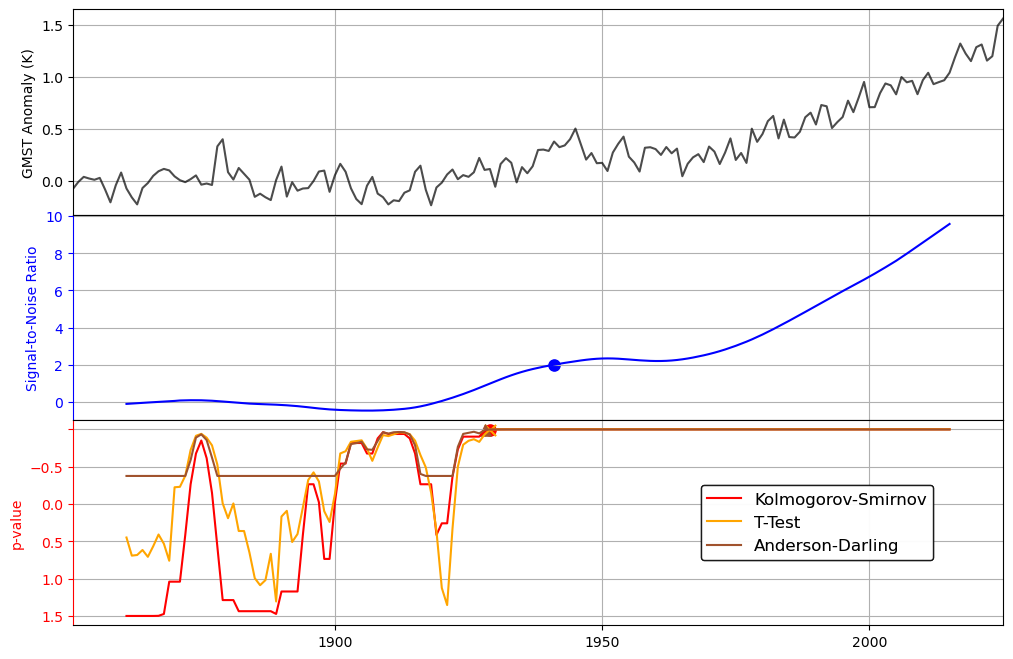

In [192]:
time_of_emergence_plots.plot_multiseries_with_pvalues(
    toe_metrics_ds,
    toe_ds,
    best_ds_smean,
    labels={'ylabel_bottom': 'GMST Anomaly (K)'}
    )


In [350]:
central_year  = 1883
period_of_interest_ds = best_ds_smean.sel(time=best_ds_smean.time.dt.year.isin(np.arange(central_year-10, central_year+11)))

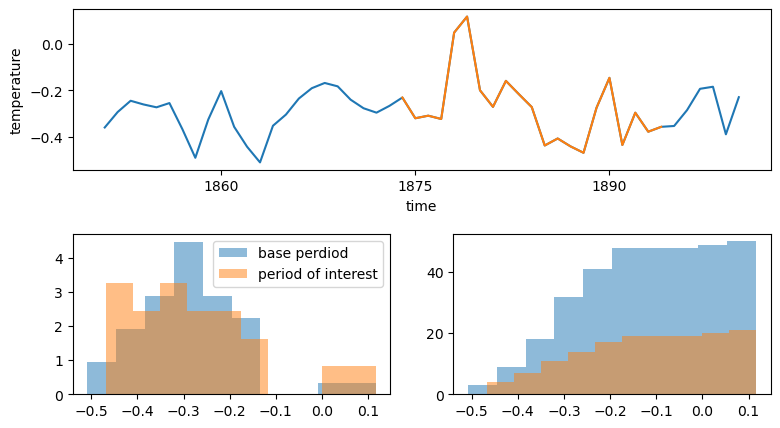

In [351]:
fig  = plt.figure(figsize=(9, 5))
gs = gridspec.GridSpec(2, 2, hspace=0.4)
ax_top = fig.add_subplot(gs[0, :])
axes_bottom = [fig.add_subplot(gs[1, i]) for i in [0, 1]]

base_period_ds.plot(ax=ax_top)
period_of_interest_ds.plot(ax=ax_top)
axes_bottom[0].hist(base_period_ds.values, density=True, alpha=0.5, label='base perdiod');
axes_bottom[0].hist(period_of_interest_ds.values, density=True, alpha=0.5, label='period of interest');
axes_bottom[0].legend(ncol=1)

axes_bottom[1].hist(base_period_ds.values, cumulative=True, alpha=0.5);
axes_bottom[1].hist(period_of_interest_ds.values, cumulative=True, alpha=0.5);